In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import math
warnings.filterwarnings('ignore')

In [65]:
def train_test_split(df, test_size):

  if isinstance(test_size, float):
    test_size = round(test_size*len(df))
  
  indices = df.index.tolist() # random.sample takes list, set, dictionary
  test_indices = random.sample(population=indices, k=test_size)

  test = df.loc[test_indices]
  train = df.drop(test_indices)

  return train, test

In [66]:
def calculate_prior_probabilities(df):

  prior_probabilities = df.groupby(by = 'target').apply(lambda x: len(x)/len(df))

  return np.log(prior_probabilities).values

In [67]:
def return_statistics(df):

  mean = df.groupby(by='target').apply(lambda x: x.mean(axis=0))
  variance = df.groupby(by='target').apply(lambda x: x.var(axis=0))

  return (mean.values, variance.values)

In [69]:
def calculate_probability_density(mean, variance, x):

  probability_density = (1 / np.sqrt(2*np.pi*variance) ) * np.exp( (-(x - mean)**2)  / ( 2*variance ) )

  return probability_density

In [70]:
def calculate_posterior_probabilities(df_row, mean, variance, n_unique_labels, n_cols):
  
  posterior_probabilities = []
  
  # calculate probabilities wrt each label to find max
  for i in range(n_unique_labels):
    posterior = 0

    # for each feature
    for j in range(n_cols):
      posterior += np.log(calculate_probability_density(mean[i][j], variance[i][j], df_row[j]))
    posterior_probabilities.append(posterior)
  
  return posterior_probabilities

In [71]:
def NBA_fit(df):

  n_cols = len(df.columns)-1
  unique_labels = df['target'].unique()
  n_unique_labels = len(unique_labels)

  mean, variance = return_statistics(df)
  prior_probabilities = calculate_prior_probabilities(df) # returns log

  return {
      'n_cols': n_cols,
      'unique_labels': unique_labels,
      'n_unique_labels': n_unique_labels,
      'mean': mean,
      'variance': variance,
      'prior_probabilities': prior_probabilities
  }

In [72]:
def predict(test_df, nba):

  predictions = []
  for i in range(len(test_df)):

    prior = nba['prior_probabilities']
    posterior = calculate_posterior_probabilities(test_df.iloc[i, :-1], nba['mean'], nba['variance'], nba['n_unique_labels'], nba['n_cols'])  # returns log
    probabilities = prior + posterior
    # one with max prob will be the output 
    mx_idx = np.argmax(probabilities)

    predictions.append(nba['unique_labels'][mx_idx])  # add log values

  return predictions

In [73]:
df = pd.read_csv (r'C:\Users\Kartik\Desktop\titanic.csv')

In [74]:
df.dropna(inplace=True)

In [75]:
df.reset_index(drop = True, inplace = True)

In [76]:
df.drop(['PassengerId','Name','Ticket','Cabin','Embarked'],axis='columns',inplace=True)

In [77]:
condition_M = df.Sex == "male"
condition_B = df.Sex == "female"
df.loc[condition_M,"Sex"]=1
df.loc[condition_B,"Sex"]=0

In [88]:
X = df.iloc[: ,:-1]
y = df.iloc[:, -1]

In [80]:
df.rename(columns={'Survived': 'target'}, inplace = True)

In [81]:
df

,Pclass,Sex,Age,Fare,target
0,1,0,38.0,71.2833,1
1,1,0,35.0,53.1000,1
2,1,1,54.0,51.8625,0
3,3,0,4.0,16.7000,1
4,1,0,58.0,26.5500,1
...,...,...,...,...,...
178,1,0,47.0,52.5542,1
179,1,1,33.0,5.0000,0
180,1,0,56.0,83.1583,1
181,1,0,19.0,30.0000,1


In [83]:
train_df, test_df = train_test_split(df, 0.2)

# fit model
nba = NBA_fit(train_df)

# make predictions
predictions = predict(test_df, nba)

# accuracy
accuracy = len(test_df.loc[predictions == test_df['target']])/len(test_df) * 100
accuracy

27.027027027027028

In [84]:
#lets check model #2

In [114]:
import pandas as pd
import numpy as np
class gnb:
  def __init__(self, prior=None, n_class=None, 
               mean=None, variance = None, classes=None):
    # prior assumption of probability
    self.prior = prior
    # how many unique classes
    self.n_class = n_class
    # mean of x values
    self.mean = mean
    # variance of x values
    self.variance = variance
    # the unique classes present
    self.classes = classes
  # get the mean and variance of the x values
  def fit(self, x, y):
    # get the mean and variance of the x values
    self.x = x
    self.y = y
    self.mean = np.array(x.groupby(by=y).mean())
    self.variance = np.array(x.groupby(by=y).var())
    self.n_class = len(np.unique(y))
    self.classes = np.unique(y)
    self.prior = 1/self.n_class
    return self
  def mean_var(self):
    # mean and variance from the trainig data
    m = np.array(self.mean)
    v = np.array(self.variance)
    # pull and combine the corresponding mean and variance
    self.mean_var = []
    for i in range(len(m)):
      m_row = m[i]
      v_row = v[i]
      for a, b in enumerate(m_row):
        mean = b
        var = v_row[a]
        self.mean_var.append([mean, var])
    return self.mean_var
  def split(self):
    spt = np.vsplit(np.array(self.mean_var()), self.n_class)
    return spt
  def gnb_base(self, x_val, x_mean, x_var):
    # define the base formula for prediction probabilities
    # Variance of the x value in question
    self.x_val = x_val
    # x mean value
    self.x_mean = x_mean
    # the x value that is being used for computation
    self.x_var = x_var
    # natural log
    e = np.e
    # pi
    pi = np.pi
    # first part of the equation
    # 1 divided by the sqrt of 2 * pi * x_variance
    equation_1 = 1/(np.sqrt(2 * pi * x_var))
    
    # second part of equation implementation
    # denominator of equation
    denom = 2 * x_var
    # numerator calculation
    numerator = (x_val - x_mean) ** 2
    # the exponent
    expo = np.exp(-(numerator/denom))
    prob = equation_1 * expo
    return prob
  def predict(self, X):
    self.X = X
    # calculate the probabilities using base formula above
    # defining the mean and variance that has being split into
    # various classes.
    split_class = self.split()
    prob = []
    for i in range(self.n_class):
      # first class
      class_one = split_class[i]
      for i in range(len(class_one)):
        # first value in class one
        class_one_x_mean = class_one[i][0]
        class_one_x_var = class_one[i][1]
        x_value = X[i]
        # now calculate the probabilities of each class. 
        prob.append([self.gnb_base(x_value, class_one_x_mean, 
                                   class_one_x_var)])
      # turn prob into an array
      prob_array = np.array(prob)
      # split the probability into various classes again
      prob_split = np.vsplit(prob_array, self.n_class)
      # calculate the final probabilities
      final_probabilities = []
      for i in prob_split:
        class_prob = np.prod(i) * self.prior
        final_probabilities.append(class_prob)
      # determining the maximum probability 
      maximum_prob = max(final_probabilities)
      # getting the index that corresponds to maximum probability
      prob_index = final_probabilities.index(maximum_prob)
      # using the index of the maximum probability to get
      # the class that corresponds to the maximum probability
      prediction = self.classes[prob_index]
      return prediction


In [115]:
df2 =  pd.read_csv (r'C:\Users\Kartik\Desktop\titanic.csv')

,PassengerId,Name,Pclass,Sex,Age,Ticket,Fare,Cabin,Embarked,Survived
0,1,"Braund, Mr. Owen Harris",3,male,22.0,A/5 21171,7.2500,NaN,S,0
1,2,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,female,38.0,PC 17599,71.2833,C85,C,1
2,3,"Heikkinen, Miss. Laina",3,female,26.0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,female,35.0,113803,53.1000,C123,S,1
4,5,"Allen, Mr. William Henry",3,male,35.0,373450,8.0500,NaN,S,0
...,...,...,...,...,...,...,...,...,...,...
886,887,"Montvila, Rev. Juozas",2,male,27.0,211536,13.0000,NaN,S,0
887,888,"Graham, Miss. Margaret Edith",1,female,19.0,112053,30.0000,B42,S,1
888,889,"Johnston, Miss. Catherine Helen ""Carrie""",3,female,NaN,W./C. 6607,23.4500,NaN,S,0
889,890,"Behr, Mr. Karl Howell",1,male,26.0,111369,30.0000,C148,C,1


In [116]:
df2.dropna(inplace=True)
df2.dropna(inplace=True)
df2.reset_index(drop = True, inplace = True)
df2.drop(['PassengerId','Name','Ticket','Cabin','Embarked'],axis='columns',inplace=True)
condition_M = df2.Sex == "male"
condition_B = df2.Sex == "female"
df2.loc[condition_M,"Sex"]=1
df2.loc[condition_B,"Sex"]=0


In [118]:
X

,Pclass,Sex,Age,Fare
0,1,0,38.0,71.2833
1,1,0,35.0,53.1000
2,1,1,54.0,51.8625
3,3,0,4.0,16.7000
4,1,0,58.0,26.5500
...,...,...,...,...
178,1,0,47.0,52.5542
179,1,1,33.0,5.0000
180,1,0,56.0,83.1583
181,1,0,19.0,30.0000


In [119]:
X2 = df.iloc[: ,:-1]
y2 = df.iloc[:, -1]

In [120]:
from sklearn.model_selection import train_test_split
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2,y2,test_size=0.2)

In [121]:
gnb = gnb()
gnb.fit(X_train2, y_train2)

In [129]:
gnb.mean_var()

TypeError: 'list' object is not callable

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

In [33]:
data = pd.read_csv(r'C:\Users\Kartik\Desktop\titanic.csv')
data.head(10)

,PassengerId,Name,Pclass,Sex,Age,Ticket,Fare,Cabin,Embarked,Survived
0,1,"Braund, Mr. Owen Harris",3,male,22.0,A/5 21171,7.2500,NaN,S,0
1,2,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,female,38.0,PC 17599,71.2833,C85,C,1
2,3,"Heikkinen, Miss. Laina",3,female,26.0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,female,35.0,113803,53.1000,C123,S,1
4,5,"Allen, Mr. William Henry",3,male,35.0,373450,8.0500,NaN,S,0
5,6,"Moran, Mr. James",3,male,NaN,330877,8.4583,NaN,Q,0
6,7,"McCarthy, Mr. Timothy J",1,male,54.0,17463,51.8625,E46,S,0
7,8,"Palsson, Master. Gosta Leonard",3,male,2.0,349909,21.0750,NaN,S,0
8,9,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",3,female,27.0,347742,11.1333,NaN,S,1
9,10,"Nasser, Mrs. Nicholas (Adele Achem)",2,female,14.0,237736,30.0708,NaN,C,1


In [34]:
data.dropna(inplace=True)
data.dropna(inplace=True)
data.reset_index(drop = True, inplace = True)

In [35]:
data.drop(['PassengerId','Name','Ticket','Cabin','Embarked'],axis='columns',inplace=True)
condition_M = data.Sex == "male"
condition_B = data.Sex == "female"
data.loc[condition_M,"Sex"]=1
data.loc[condition_B,"Sex"]=0

In [36]:

data.head()

,Pclass,Sex,Age,Fare,Survived
0,1,0,38.0,71.2833,1
1,1,0,35.0,53.1000,1
2,1,1,54.0,51.8625,0
3,3,0,4.0,16.7000,1
4,1,0,58.0,26.5500,1


<AxesSubplot:>

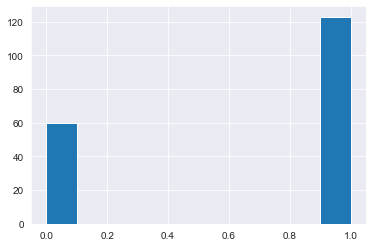

In [37]:
data["Survived"].hist()

<AxesSubplot:>

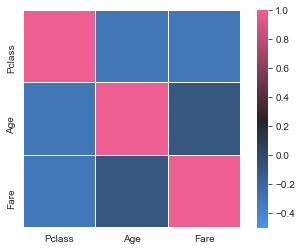

In [38]:
corr = data.iloc[:,:-1].corr(method="pearson")
cmap = sns.diverging_palette(250,354,80,60,center='dark',as_cmap=True)
sns.heatmap(corr, vmax=1, vmin=-.5, cmap=cmap, square=True, linewidths=.2)

In [39]:
def calculate_prior(df, Y):
    classes = sorted(list(df[Y].unique()))
    prior = []
    for i in classes:
        prior.append(len(df[df[Y]==i])/len(df))
    return prior

In [40]:
def calculate_likelihood_gaussian(df, feat_name, feat_val, Y, label):
    feat = list(df.columns)
    df = df[df[Y]==label]
    mean, std = df[feat_name].mean(), df[feat_name].std()
    p_x_given_y = (1 / (np.sqrt(2 * np.pi) * std)) *  np.exp(-((feat_val-mean)**2 / (2 * std**2 )))
    return p_x_given_y

In [41]:
def naive_bayes_gaussian(df, X, Y):
    # get feature names
    features = list(df.columns)[:-1]

    # calculate prior
    prior = calculate_prior(df, Y)

    Y_pred = []
    # loop over every data sample
    for x in X:
        # calculate likelihood
        labels = sorted(list(df[Y].unique()))
        likelihood = [1]*len(labels)
        for j in range(len(labels)):
            for i in range(len(features)):
                likelihood[j] *= calculate_likelihood_gaussian(df, features[i], x[i], Y, labels[j])

        # calculate posterior probability (numerator only)
        post_prob = [1]*len(labels)
        for j in range(len(labels)):
            post_prob[j] = likelihood[j] * prior[j]

        Y_pred.append(np.argmax(post_prob))

    return np.array(Y_pred) 

In [29]:
q = data.iloc[:, 0]
q

0      1
1      1
2      1
3      1
4      1
      ..
564    1
565    1
566    1
567    1
568    0
Name: diagnosis, Length: 569, dtype: object

In [43]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=.2, random_state=41)

X_test = data.iloc[:,:-1].values
Y_test = data.iloc[:,-1].values
Y_pred = naive_bayes_gaussian(train, X=X_test, Y="Survived")

from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
print(confusion_matrix(Y_test, Y_pred))
print(f1_score(Y_test, Y_pred))
print(accuracy_score(Y_test, Y_pred))


[[50 10]
 [37 86]]
0.7853881278538812
0.7431693989071039
